# ENSO statistics for all ensemble members of CESM2 historical

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from scipy import signal

%matplotlib inline

import xarray as xr
import intake
import pprint 

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [3]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 698724 entries:
	> 13 activity_id(s)

	> 24 institution_id(s)

	> 47 source_id(s)

	> 68 experiment_id(s)

	> 162 member_id(s)

	> 35 table_id(s)

	> 1027 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 248 version(s)

	> 6813 time_range(s)

	> 698724 path(s)

In [4]:
cat = col.search(experiment_id=['historical'], variable_id='ts', grid_label='gn', source_id='CESM2',table_id='Amon')

cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
87842,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,ts,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
90273,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,ts,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
92508,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,ts,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
94743,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,ts,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
96978,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,ts,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
101585,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,ts,gn,NaN,v20190311,200001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
101586,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,ts,gn,NaN,v20190311,190001-194912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
101587,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,ts,gn,NaN,v20190311,195001-199912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
101588,CMIP,NCAR,CESM2,historical,r9i1p1f1,Amon,ts,gn,NaN,v20190311,185001-189912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
106551,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,ts,gn,NaN,v20190311,190001-194912,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...


In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
dset_dict.keys()



xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dict_keys(['CMIP.NCAR.CESM2.historical.Amon.gn'])

In [6]:
ds = dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn']
ds = ds.roll(member_id = -2, roll_coords=True) # reorder emsemble members

In [7]:
sst_clim = ds.ts.groupby('time.month').mean(dim='time')
sst_anom = ds.ts.groupby('time.month') - sst_clim

sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom, kwargs={'axis': 1}, dask = 'allowed')

In [8]:
weights = np.cos(np.deg2rad(ds.lat))
weights /= weights.mean()

sst_anom_global = (sst_anom * weights).mean(dim=['lon', 'lat'])
sst_anom_global_detrended = (sst_anom_detrended * weights).mean(dim=['lon', 'lat'])

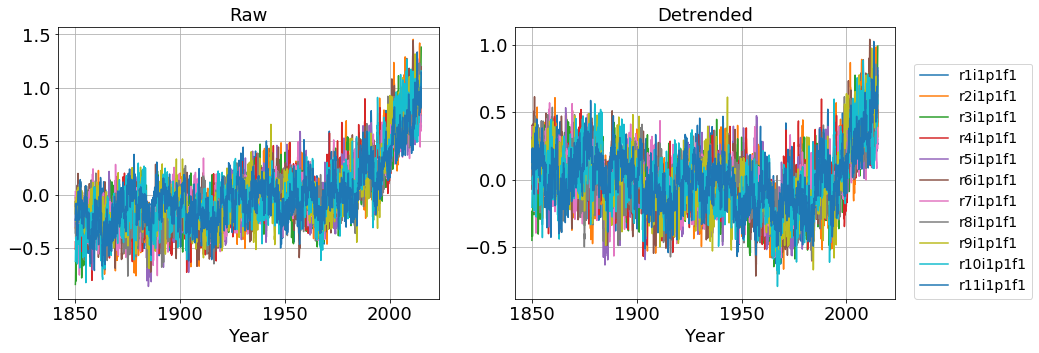

In [9]:
fig, axes = plt.subplots(ncols=2, figsize = (15,5))

for i in range(sst_anom_global.member_id.size):
    member_id = sst_anom_global.member_id.values[i]
    sst_anom_global.isel(member_id = i).plot.line(ax=axes[0], x = 'time', label = member_id, add_legend = False)
    sst_anom_global_detrended.isel(member_id = i).plot.line(ax=axes[1], x = 'time',add_legend = False)

for ax in axes:
    ax.grid()
    ax.tick_params(axis='both', labelsize = 18)
    ax.set_xlabel('Year', fontsize = 18)

axes[0].set_title('Raw', fontsize = 18)
axes[1].set_title('Detrended', fontsize = 18);
axes[0].legend(fontsize = 14, loc = (2.25,0));


In [10]:
# Select regions from lat=range(5, -5) and lon=range(190, 240)
sst_anom_nino34 = sst_anom_detrended.sel(lat=slice(-5, 5), lon=slice(190, 240))
# Compute a moving temporal average
sst_anom_nino34_mean = (sst_anom_nino34*weights.sel(lat=slice(-5, 5))).mean(dim=('lon', 'lat'))
nino34_index = sst_anom_nino34_mean.rolling(time=3, center=True).mean()

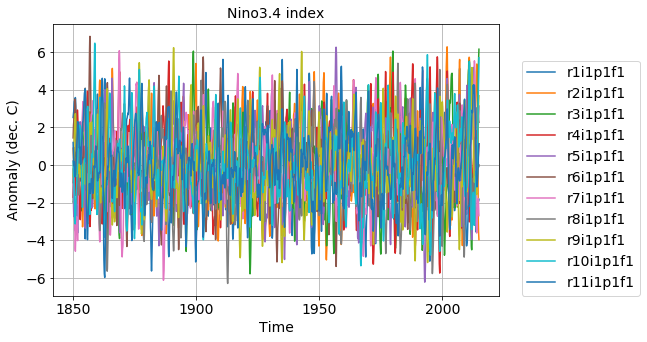

In [11]:
fig, axes = plt.subplots(figsize = (8,5))

for i in range(sst_anom_global.member_id.size):
    member_id = sst_anom_global.member_id.values[i]
    nino34_index.isel(member_id = i).plot.line(ax = axes, x = 'time',label = member_id, add_legend=False)
plt.grid()
plt.ylabel('Anomaly (dec. C)', fontsize = 14);
axes.set_title('Nino3.4 index', fontsize = 14);
plt.tick_params(axis='both', labelsize = 14)
plt.xlabel('Time', fontsize = 14)
plt.legend(loc=(1.05,0), fontsize = 14);

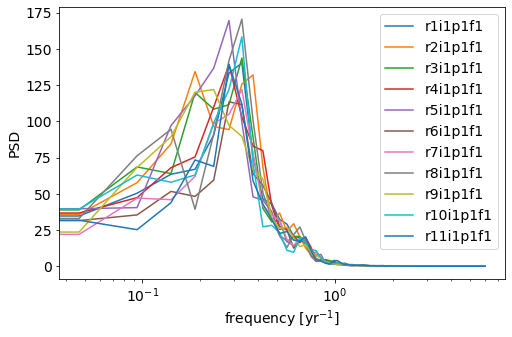

In [12]:
fig, ax = plt.subplots(figsize = (8,5))

for i in range(nino34_index.member_id.size):
    x = nino34_index.isel(member_id = i).dropna('time')
    f, Pxx_den = signal.welch(x)
    plt.semilogx(f*12, Pxx_den, label = nino34_index.member_id.values[i])
plt.xlabel('frequency [yr$^{-1}$]', fontsize = 14)
plt.ylabel('PSD', fontsize = 14)
ax.legend(fontsize = 14)
plt.tick_params(axis='both', labelsize = 14)
plt.show()


# EOF of equatorial ts for first ensemble member

In [13]:
from eofs.xarray import Eof

data = sst_anom_detrended.isel(member_id = 0).transpose('time', 'lon', 'lat')
eq_band = data.sel(lat = slice(-20,20))
solver = Eof(eq_band, weights=np.sqrt(weights.sel(lat = slice(-20, 20))))
eof1 = solver.eofsAsCorrelation(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)

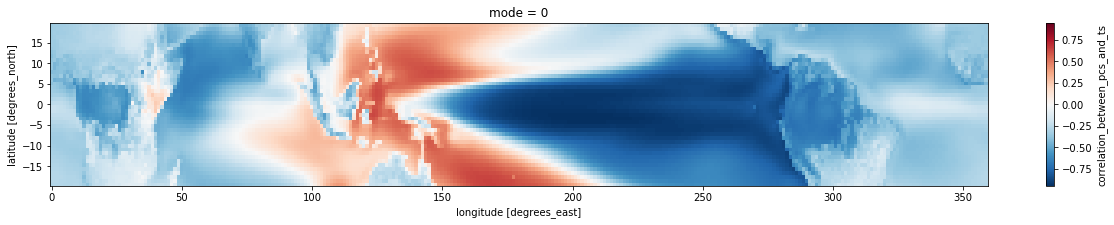

In [14]:
eof1.transpose('mode','lat','lon').plot(size = 3, aspect = 7)

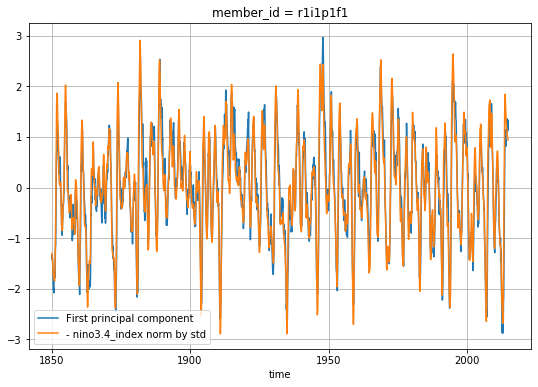

In [15]:
pc1.sel(mode=0).plot(label='First principal component', size = 6)
(-nino34_index.isel(member_id = 0)/np.std(nino34_index.isel(member_id = 0))).plot(label='- nino3.4_index norm by std')
plt.grid()
plt.legend();

# EOFs of equatorial ts for all ensemble members

In [16]:
eof1list = {}
pc1list = {}
for i in range(nino34_index.member_id.size):
    data = sst_anom_detrended.isel(member_id = i).transpose('time', 'lon', 'lat')
    eq_band = data.sel(lat = slice(-20,20))
    solver = Eof(eq_band, weights=np.sqrt(weights.sel(lat = slice(-20, 20))))
    eof1 = solver.eofsAsCorrelation(neofs=1)
    pc1 = solver.pcs(npcs=1, pcscaling=1)
    
    # store values:
    eof1list[nino34_index.member_id.values[i]] = eof1
    pc1list[nino34_index.member_id.values[i]] = pc1

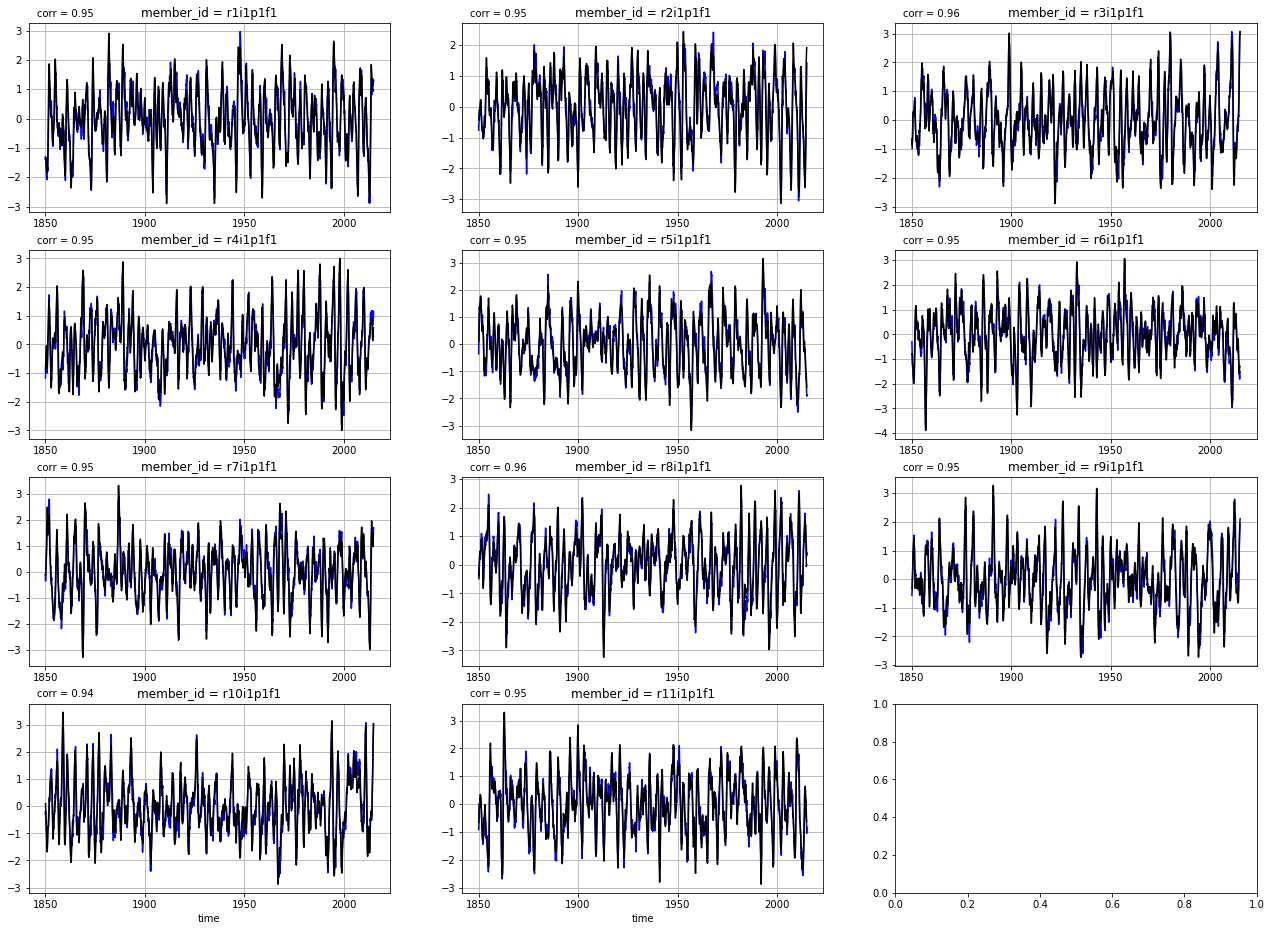

In [20]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (22,16))
colors = ['blue', 'black']

for i in range(nino34_index.member_id.size):
    member_id = nino34_index.member_id.values[i]
    axis = np.reshape(axes, 12)[i]
    pc1 = pc1list[member_id].sel(mode=0)
    nino34_norm = (- nino34_index.isel(member_id = i)/np.std(nino34_index.isel(member_id = i))).dropna('time')
    corr = np.round(np.corrcoef(pc1[1:-1], nino34_norm)[0,1],2)
    
    axis.text(0.1,1.05,'corr = ' + str(abs(corr)), horizontalalignment='center', verticalalignment='center', transform=axis.transAxes)
    pc1.plot(ax = axis, color = colors[0], label='First principal component')
    if corr > 0:
        nino34_norm.plot(ax=axis, color = colors[1], label='- nino3.4_index norm by std')
    else:
        (-nino34_norm).plot(ax=axis, color = colors[1], label='nino3.4_index norm by std')
    if i < 9:
        axis.set_xlabel('')
    axis.grid()
